## 人工智能导论第二次作业-分类实践
覃果 2020012379 软02

## 导入数据

In [1]:
# 导入包
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')

In [2]:
# 读入数据
raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")
# 调整列名
raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

## 数据清洗
* 把缺失比例大于 0.99 的列去除
* 将这些对预测没有帮助的行去除
* 将非数字的项进行替换
* 将nan替换为均值


total miss_rate 0.8806003026414082


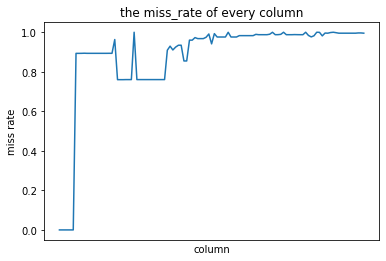

In [3]:
# 首先查看空值的情况
miss_rate = raw_data.isnull().sum().sum()/(raw_data.shape[0] * raw_data.shape[1])
miss_rate_every_col = raw_data.isnull().sum()/raw_data.shape[0]
print('total miss_rate', miss_rate)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.title("the miss_rate of every column")
plt.xlabel("column")
plt.ylabel("miss rate")
plt.plot(miss_rate_every_col)

the number of columns the miss_rate > 0.99 which means the colum just have about 50 datas in 5644 rows: 24


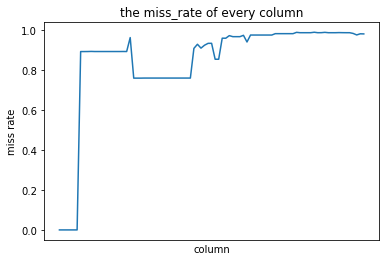

In [4]:
# 可以看到有很多列的缺失比例是很高的
# 我们把缺失比例大于 0.99 的列去除
threshold = 0.99
to_drop = [x for x in miss_rate_every_col.index if miss_rate_every_col[x] > threshold]
print("the number of columns the miss_rate > 0.99 which means the colum just have about 50 datas in 5644 rows:",len(to_drop))
data = raw_data.drop(columns=to_drop)
miss_rate_every_col = data.isnull().sum()/data.shape[0]
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.title("the miss_rate of every column")
plt.xlabel("column")
plt.ylabel("miss rate")
plt.plot(miss_rate_every_col)

In [5]:
# 再查看行的空值情况
miss_rate_every_row = data.isnull().sum(axis=1)/data.shape[1]
threshold = 0.93 # 1 - 6/(111 - 25)
to_drop = [x for x in miss_rate_every_row.index if miss_rate_every_row[x] > threshold]
print("the number of rows the miss_rate > 0.93 which means the row just have 6 datas to be predicted:",len(to_drop))
# 将这些对预测没有帮助的行去除
data = data.drop(index=to_drop)

the number of rows the miss_rate > 0.93 which means the row just have 6 datas to be predicted: 3544


In [6]:
#将非数字的项进行替换
for y in data.columns:
    if data[y].dtype == "object":
        lbl = LabelEncoder()
        lbl.fit(list(data[y].values))
        data[y] = lbl.transform(list(data[y].values))
# 将nan替换为均值
for x in data.columns:
    data[x].fillna(data[x].mean(), inplace=True)

## 特征工程
* 将要预测的列以及无用的id去除
* 将方差较小的列去除
* 将相关性较高的列去除
* pac/nmf/lda

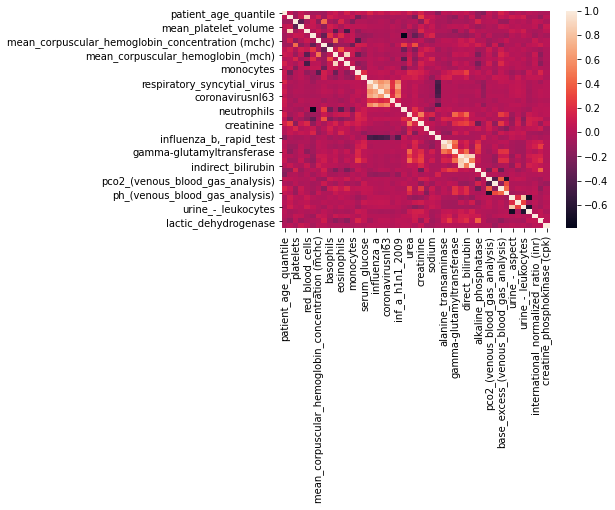

In [7]:
def feature_origin(data):
    # 首先将要预测的列以及无用的id去除
    label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
    cols = [x for x in data.columns if x not in label_col] # These columns are the features we can use to predict
    data_train = data[cols]
    # 将方差较小的列去除
    to_drop = []
    for x in data_train.columns:
        if data_train[x].var() < 0.95*(1 - 0.95):
            to_drop.append(x)
    data_train = data_train.drop(columns=to_drop)
    # 然后将相关性较高的列去除
    corr_matrix = data_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    threshold = 0.9
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    data_train = data_train.drop(columns=to_drop)
    # 可视化现在的相关性
    sns.heatmap(data_train.corr())
    return data_train
data_train = feature_origin(data)

## TODO1
我们将采用Principal component analysis,所有元素取对数后的Non-negative matrix factorization,以及Latent Dirichlet Allocation三种方式进行特征工程

效果的测试将在其他模块完成后进行

In [8]:
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
def feature_by_pca(data, n_components):
    pca = PCA(n_components=n_components)
    return pd.DataFrame(pca.fit_transform(data))
def feature_by_NMF(data, n_components):
    from math import exp
    exp_data = data.applymap(lambda x : exp(x))
    nmf = NMF(n_components=n_components, init='random', random_state=0)
    return pd.DataFrame(nmf.fit_transform(exp_data))
def feature_by_LDA(data, n_components):
    from math import exp
    exp_data = data.applymap(lambda x : exp(x))
    lda = LatentDirichletAllocation(n_components=n_components)
    return pd.DataFrame(lda.fit_transform(exp_data))
# 效果的测试将在其他模块完成后进行

## TODO2
我们将采用Knn, Logistic Regression, Decision Tree, Random Forest, MLP六个模型
其中我们将手动实现Knn

并对各个模型进行训练同时可视化其模型的accuracy 和 f1 score

In [9]:
# knn
class KNN(object):
    def __init__(self, n_neighbors):
        self.neighbors = n_neighbors

    def fit(self, X_train, y_train):
        if not isinstance(X_train, np.ndarray):
            self.X_train = X_train.copy().to_numpy()
        else:
            self.X_train = X_train.copy()
        if not isinstance(y_train, np.ndarray):
            self.y_train = y_train.copy().to_numpy()
        else:
            self.y_train = y_train.copy()
    def distance(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2))
    def k_nearest(self, sample):
        dis = [(self.y_train[i], self.distance(self.X_train[i], sample)) for i in range(len(self.X_train))]
        dis.sort(key=lambda x: x[1])
        labels = []
        for i in range(self.neighbors):
            labels.append(dis[i][0])
        return labels

    def predict(self, X_test):
        if not isinstance(X_test, np.ndarray):
            test = X_test.copy().to_numpy()
        else:
            test = X_test.copy()
        pred = []
        for i in range(len(X_test)):
            labels = self.k_nearest(test[i])
            label = max(labels, key=labels.count)
            pred.append(label)
        return pred

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
model_list = []
model_list.append({'name':'KNN', 'model':KNeighborsClassifier(n_neighbors=7, n_jobs=-1)})
model_list.append({'name':'myKNN', 'model':KNN(n_neighbors=7)})
model_list.append({'name':'LR', 'model': LogisticRegression(class_weight={0:0.2, 1:0.8}, n_jobs=-1, solver='sag')})
model_list.append({'name':'svm', 'model': svm.SVC(class_weight={0:0.2, 1:0.8}, probability=True)})
model_list.append({'name':'DT', 'model': DecisionTreeClassifier(random_state=101)})
model_list.append({'name':'RF', 'model': RandomForestClassifier(n_estimators=20, random_state=101, n_jobs=-1)})
model_list.append({'name': 'MLP', 'model': MLPClassifier(hidden_layer_sizes=(150,), max_iter=100000, random_state=101)})

accuracy_list = []
f1_score_list = []
def data_split(data_to_split, predict, test_size,  random_state=101):
    y = data[predict]
    return train_test_split(data_to_split, y, test_size=test_size, random_state=random_state)

def model_assess(model, name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    cm = confusion_matrix(y_test, prds)
    accuracy_list.append(accuracy_score(y_test, prds))
    f1_score_list.append(f1_score(y_test, prds))
    print('------------------------------------------------')
    print('name', name)
    print('confusion_matirx: \n',cm)
    print("report: \n", classification_report(y_test, prds, digits=3)) 
def run():
    X_train, X_test, y_train, y_test = data_split(data_train,'sars-cov-2_exam_result', 0.33)
    for model in model_list:
        model_assess(model['model'], model['name'], X_train, X_test, y_train, y_test)
run()

------------------------------------------------
name KNN
confusion_matirx: 
 [[631   1]
 [ 60   1]]
report: 
               precision    recall  f1-score   support

           0      0.913     0.998     0.954       632
           1      0.500     0.016     0.032        61

    accuracy                          0.912       693
   macro avg      0.707     0.507     0.493       693
weighted avg      0.877     0.912     0.873       693

------------------------------------------------
name myKNN
confusion_matirx: 
 [[631   1]
 [ 60   1]]
report: 
               precision    recall  f1-score   support

           0      0.913     0.998     0.954       632
           1      0.500     0.016     0.032        61

    accuracy                          0.912       693
   macro avg      0.707     0.507     0.493       693
weighted avg      0.877     0.912     0.873       693

------------------------------------------------
name LR
confusion_matirx: 
 [[593  39]
 [ 42  19]]
report: 
             

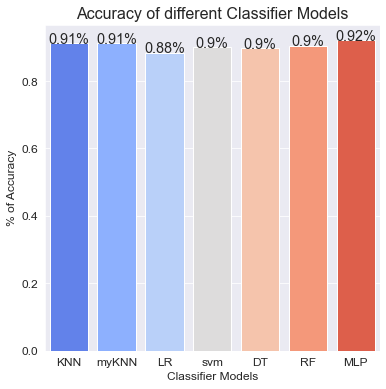

In [11]:
# 可视化结果 accuracy
def acc_plot():
    model_list_name = [x['name'] for x in model_list]
    plt.rcParams['figure.figsize']=6,6
    sns.set_style('darkgrid')
    ax = sns.barplot(x=model_list_name, y = accuracy_list, palette = "coolwarm", saturation =2.0)
    plt.xlabel('Classifier Models', fontsize = 12)
    plt.ylabel('% of Accuracy', fontsize = 12)
    plt.title('Accuracy of different Classifier Models', fontsize = 16)
    plt.xticks(fontsize = 12, horizontalalignment = 'center')
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
    plt.show()
acc_plot()

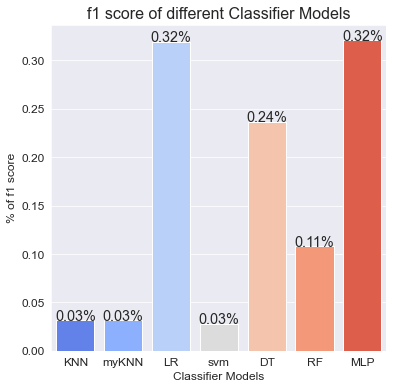

{'name': 'myKNN', 'model': <__main__.KNN at 0x24e6798d880>}

In [12]:
# 可视化结果 f1-score
def f1_plot():
    model_list_name = [x['name'] for x in model_list]
    plt.rcParams['figure.figsize']=6,6
    sns.set_style('darkgrid')
    ax = sns.barplot(x=model_list_name, y = f1_score_list, palette = "coolwarm", saturation =2.0)
    plt.xlabel('Classifier Models', fontsize = 12)
    plt.ylabel('% of f1 score', fontsize = 12)
    plt.title('f1 score of different Classifier Models', fontsize = 16)
    plt.xticks(fontsize = 12, horizontalalignment = 'center')
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
    plt.show()
f1_plot()
# 可以看到手写的knn和sklearn内置的knn效果相同，为了简单起见，将手写的knn移出model_list
model_list.pop(1)

## TODO3
使用交叉验证选择模型的超参数，由于数据阴性和阳性数据很不平衡，所以我们选择f1_score作为选择的标准

并可视化其f1 score 和 roc, auc

In [13]:
from sklearn.model_selection import GridSearchCV
class_weight = [{0:0.1, 1:0.9}, {0:0.15, 1:0.85},{0:0.2, 1:0.8}, {0:0.25, 1:0.75}, {0:0.3, 1:0.7},{0:0.35, 1:0.65}, {0:0.4, 1:0.6},{0:0.45, 1:0.55}, {0:0.5, 1:0.5}]
parameters = [{'n_neighbors': np.arange(1, 25)}, {'penalty':['l1', 'l2', 'elasticnet'], 'class_weight': class_weight, 'solver' :['sag']}, {'class_weight': class_weight, 'kernel' : ['rbf']},
{'class_weight': class_weight, 'criterion' : ["gini", "entropy"]}, {'class_weight': class_weight, 'criterion' : ["gini", "entropy"], 'n_estimators': np.arange(5, 25)},
{'hidden_layer_sizes':[(100, ), (200, ), (250, ), (50, 50), (50, 100)]}]

def model_select(X_train, X_test, y_train, y_test):
    f1_score_train = []
    f1_score_test = []
    final_model = []
    for i, model in enumerate(model_list):
        gs = GridSearchCV(estimator=model['model'], param_grid=parameters[i], refit=True, cv=5, n_jobs=-1, scoring='f1')
        gs.fit(X_train, y_train)
        print('-------------------------------------------------------------------------')
        print('name:', model['name'])
        print('best parameter', gs.best_params_)
        print('best train f1 score:', gs.best_score_)
        print('best test f1 score:', gs.score(X_test, y_test))
        f1_score_train.append(gs.best_score_)
        f1_score_test.append(gs.score(X_test, y_test))
        final_model.append(gs.best_estimator_)
    return f1_score_train, f1_score_test, final_model

X_train, X_test, y_train, y_test = data_split(data_train,'sars-cov-2_exam_result', 0.33)
f1_score_train, f1_score_test, final_model = model_select(X_train, X_test, y_train, y_test)

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 1}
best train f1 score: 0.1672658793880191
best test f1 score: 0.21192052980132453
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.25, 1: 0.75}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.3793906845034665
best test f1 score: 0.2962962962962963
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'kernel': 'rbf'}
best train f1 score: 0.21164240957228073
best test f1 score: 0.21848739495798317
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.45, 1: 0.55}, 'criterion': 'gini'}
best train f1 score: 0.24988118069366236
best test f1 score: 0.22000000000000003
-------------------------------------------------------------------------
name: RF
be

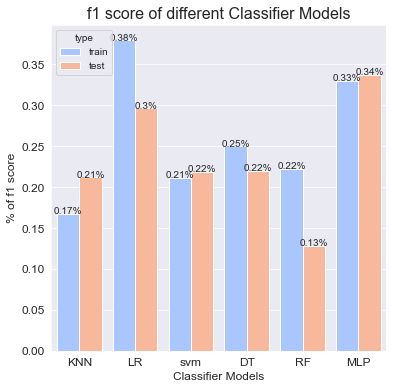

In [14]:
# 可视化 f1 score
def f1_vs_plot(f1_score_train, f1_score_test, feature_method=None):
    plot_data = pd.concat(
        [pd.DataFrame({'name':[x['name'] for x in model_list],'score': f1_score_train,"type": 'train'}),
            pd.DataFrame({'name':[x['name'] for x in model_list],'score': f1_score_test,"type": 'test'})])
    plt.rcParams['figure.figsize']=6, 6
    sns.set_style('darkgrid')
    ax = sns.barplot(x='name', y = 'score', data = plot_data, hue = 'type', palette = "coolwarm", saturation =2.0)
    plt.xlabel('Classifier Models', fontsize = 12)
    plt.ylabel('% of f1 score', fontsize = 12)
    if feature_method == None:
        plt.title('f1 score of different Classifier Models', fontsize = 16)
    else:
        plt.title(f'f1 score of different Classifier Models by {feature_method}', fontsize = 16)
    plt.xticks(fontsize = 12, horizontalalignment = 'center')
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center')
    plt.show()
f1_vs_plot(f1_score_train, f1_score_test)

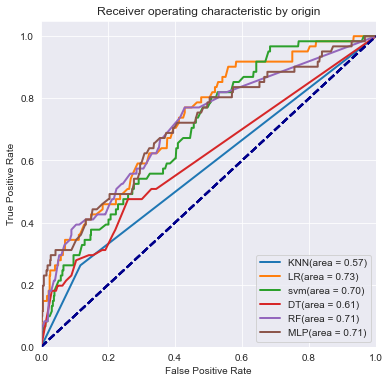

In [15]:
# 可视化 roc 和 auc
from sklearn.metrics import roc_curve, auc
auc_record = pd.DataFrame()
def roc_plot(model, X_test, y_test, name, feature_method=None):
    pred = model.predict_proba(X_test)
    pred = pd.DataFrame(pred, columns=['prob_0', 'prob_1'])
    scores = pred['prob_1']
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.rcParams['figure.figsize']=6, 6
    plt.plot(
        fpr,
        tpr,
        lw=lw,
        label=f"{name}(area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="darkblue", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if feature_method == None:
        plt.title("Receiver operating characteristic")
    else:
        plt.title(f"Receiver operating characteristic by {feature_method}")
    plt.legend(loc="lower right")
    return roc_auc
def roc_plot_all_model(X_train, X_test, y_train, y_test, final_model, feature_name):
    global auc_record
    model_list_name = [x['name'] for x in model_list]
    record = []
    for i, model in enumerate(final_model):
        record.append(roc_plot(model, X_test, y_test, model_list_name[i], feature_name))
    auc_record[feature_name] = record
    plt.show()
X_train, X_test, y_train, y_test = data_split(data_train, 'sars-cov-2_exam_result',0.33)
roc_plot_all_model(X_train, X_test, y_train, y_test, final_model, 'origin')

## TODO1
使用Random Forest,MlLP比较pca, nmf, lda三种不同特征工程的效果

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 1}
best train f1 score: 0.16096185012125158
best test f1 score: 0.2251655629139073
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.3, 1: 0.7}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.40120322002674946
best test f1 score: 0.3157894736842105
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.15, 1: 0.85}, 'kernel': 'rbf'}
best train f1 score: 0.28951366635577164
best test f1 score: 0.2718446601941748
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.45, 1: 0.55}, 'criterion': 'gini'}
best train f1 score: 0.26533603238866393
best test f1 score: 0.2524271844660194
-------------------------------------------------------------------------
name: RF
bes

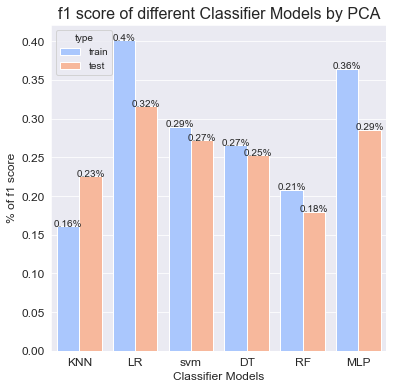

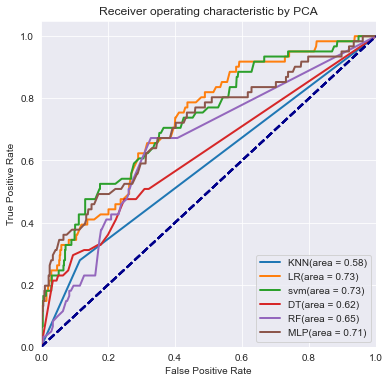

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 1}
best train f1 score: 0.03947619047619048
best test f1 score: 0.1111111111111111
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.1430541871921182
best test f1 score: 0.08571428571428572
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'kernel': 'rbf'}
best train f1 score: 0.12219696969696972
best test f1 score: 0.045454545454545456
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'entropy'}
best train f1 score: 0.1537347460303787
best test f1 score: 0.12389380530973453
-------------------------------------------------------------------------
name: RF
be

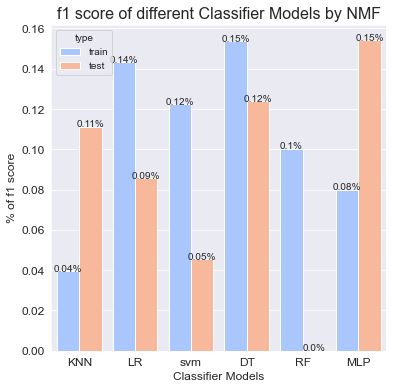

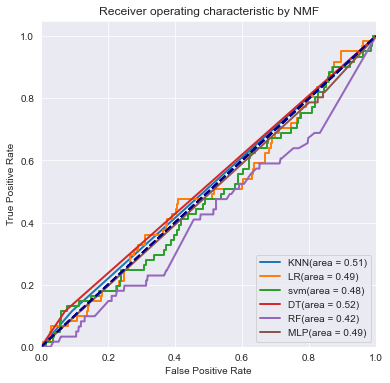

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 1}
best train f1 score: 0.10147493240472368
best test f1 score: 0.10852713178294575
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.05686609686609687
best test f1 score: 0.028571428571428574
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.3, 1: 0.7}, 'kernel': 'rbf'}
best train f1 score: 0.058666666666666666
best test f1 score: 0.0
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'criterion': 'entropy'}
best train f1 score: 0.08831340702308445
best test f1 score: 0.17600000000000002
-------------------------------------------------------------------------
name: RF
best parameter

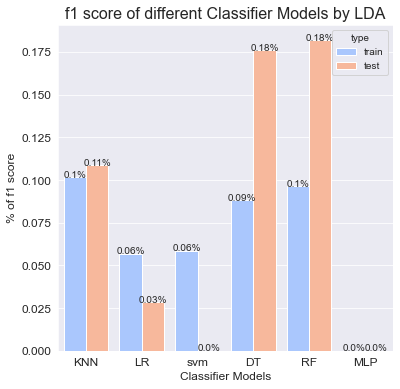

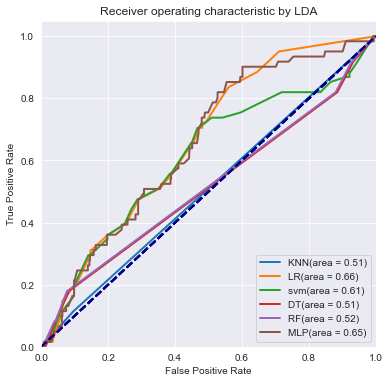

In [16]:
feature_list = [feature_by_pca, feature_by_NMF, feature_by_LDA]
feature_name_list = ['PCA', 'NMF', 'LDA']
def feature_selection():
    for i, method in enumerate(feature_list):
        data_feature = method(data_train, n_components=25)
        X_train, X_test, y_train, y_test = data_split(data_feature,'sars-cov-2_exam_result', 0.33)
        f1_score_train, f1_score_test, final_model = model_select(X_train, X_test, y_train, y_test)
        f1_vs_plot(f1_score_train, f1_score_test, feature_name_list[i])
        roc_plot_all_model(X_train, X_test, y_train, y_test, final_model, feature_name_list[i])
feature_selection()

<AxesSubplot:title={'center':'auc of different feature selected in different model'}, ylabel='auc'>

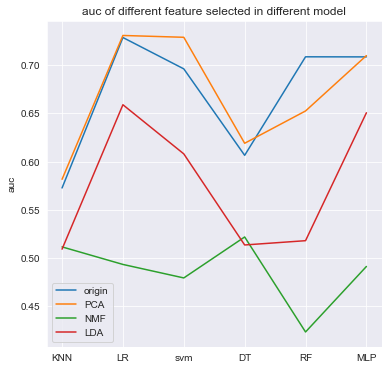

In [17]:
# 比较不同特征工程的 auc
model_list_name = [x['name'] for x in model_list]
auc_record.index = model_list_name
auc_record.plot(title="auc of different feature selected in different model", ylabel='auc')

通过观察上面的对比图可以发现采用PCA的效果最好，采用每个元素取指数后的NMF和LDA的效果比较差

个人认为是因为在取指数时对数据产生了一定的扭曲，面对非负矩阵时最好还是采用PCA

## TODO4
预测其他任务，我们选择预测 patient_addmited_to_regular_ward_(1=yes,_0=no)

### 数据清洗
* 把缺失比例大于 0.99 的列去除
* 将非数字的项进行替换
* 将nan替换为均值


In [18]:
# 我们把缺失比例大于 0.99 的列去除
miss_rate = raw_data.isnull().sum().sum()/(raw_data.shape[0] * raw_data.shape[1])
miss_rate_every_col = raw_data.isnull().sum()/raw_data.shape[0]
threshold = 0.99
to_drop = [x for x in miss_rate_every_col.index if miss_rate_every_col[x] > threshold]
print("the number of columns the miss_rate > 0.99 which means the colum just have about 50 datas in 5644 rows:",len(to_drop))
data = raw_data.drop(columns=to_drop)
#将非数字的项进行替换
for y in data.columns:
    if data[y].dtype == "object":
        lbl = LabelEncoder()
        lbl.fit(list(data[y].values))
        data[y] = lbl.transform(list(data[y].values))
# 将nan替换为均值
for x in data.columns:
    data[x].fillna(data[x].mean(), inplace=True)

the number of columns the miss_rate > 0.99 which means the colum just have about 50 datas in 5644 rows: 24


## 特征工程
* 将要预测的列以及无用的id去除
* 将方差较小的列去除
* 将相关性较高的列去除
* pac/nmf/lda


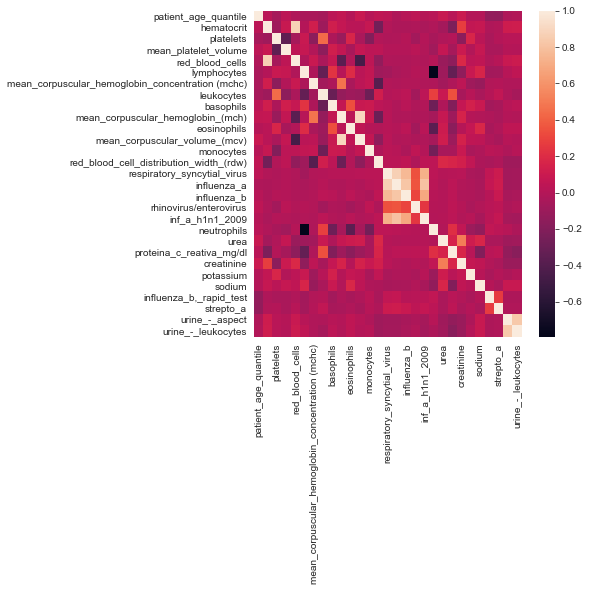

In [22]:
data_train = feature_origin(data)

## 交叉验证调节模型超参数

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 1}
best train f1 score: 0.0882051282051282
best test f1 score: 0.2285714285714286
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.2, 1: 0.8}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.15166666666666667
best test f1 score: 0.2790697674418604
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'kernel': 'rbf'}
best train f1 score: 0.0
best test f1 score: 0.0
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'entropy'}
best train f1 score: 0.07936507936507937
best test f1 score: 0.2
-------------------------------------------------------------------------
name: RF
best parameter {'class_weight': {0: 0.15, 1: 0.85},

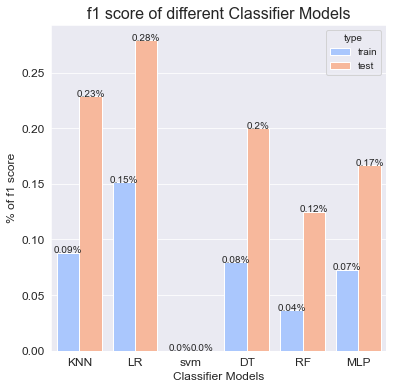

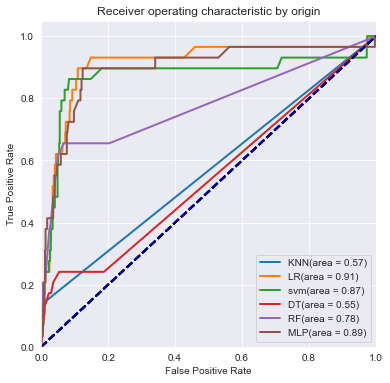

In [20]:
X_train, X_test = data_train.iloc[:5001], data_train.iloc[5001:]
y_train, y_test = data['patient_addmited_to_regular_ward_(1=yes,_0=no)'][:5001], data['patient_addmited_to_regular_ward_(1=yes,_0=no)'][5001:]
f1_score_train, f1_score_test, final_model = model_select(X_train, X_test, y_train, y_test)
f1_vs_plot(f1_score_train, f1_score_test)
roc_plot_all_model(X_train, X_test, y_train, y_test, final_model, 'origin')

## 比较不同的特征工程

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 1}
best train f1 score: 0.0882051282051282
best test f1 score: 0.2285714285714286
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.1396996996996997
best test f1 score: 0.3018867924528302
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'kernel': 'rbf'}
best train f1 score: 0.0
best test f1 score: 0.06666666666666667
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.5, 1: 0.5}, 'criterion': 'entropy'}
best train f1 score: 0.12444444444444444
best test f1 score: 0.15384615384615385
-------------------------------------------------------------------------
name: RF
best parameter {'cla

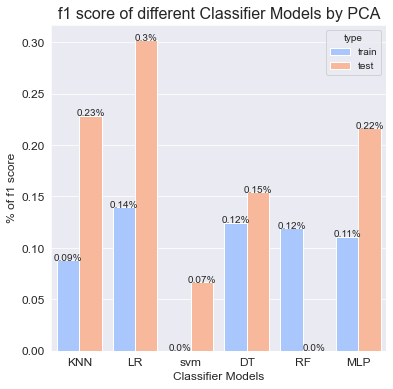

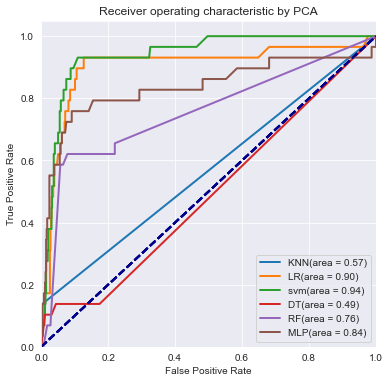

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 3}
best train f1 score: 0.03636363636363636
best test f1 score: 0.0
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.0
best test f1 score: 0.18181818181818182
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'kernel': 'rbf'}
best train f1 score: 0.07828206880838459
best test f1 score: 0.25000000000000006
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.45, 1: 0.55}, 'criterion': 'gini'}
best train f1 score: 0.052000000000000005
best test f1 score: 0.05714285714285715
-------------------------------------------------------------------------
name: RF
best parameter {'class_weight': 

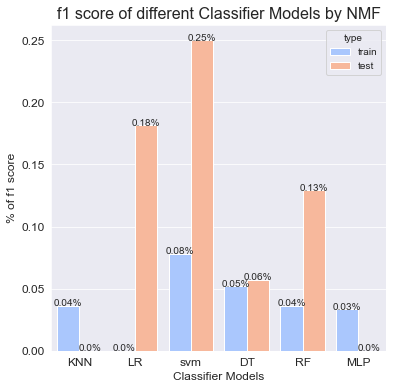

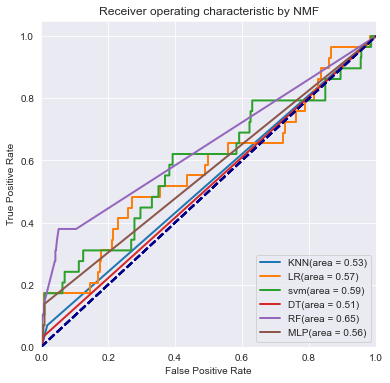

-------------------------------------------------------------------------
name: KNN
best parameter {'n_neighbors': 1}
best train f1 score: 0.028571428571428574
best test f1 score: 0.0
-------------------------------------------------------------------------
name: LR
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'penalty': 'l2', 'solver': 'sag'}
best train f1 score: 0.0
best test f1 score: 0.0
-------------------------------------------------------------------------
name: svm
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'kernel': 'rbf'}
best train f1 score: 0.0
best test f1 score: 0.0
-------------------------------------------------------------------------
name: DT
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'criterion': 'gini'}
best train f1 score: 0.030769230769230764
best test f1 score: 0.0
-------------------------------------------------------------------------
name: RF
best parameter {'class_weight': {0: 0.1, 1: 0.9}, 'criterion': 'gini', 'n_estimators': 5}
best tr

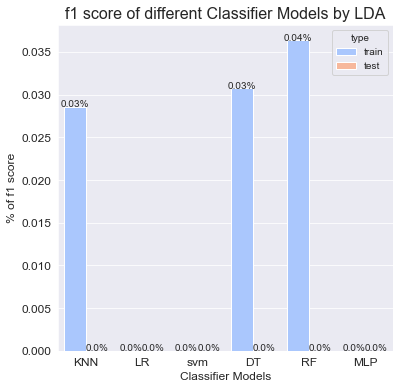

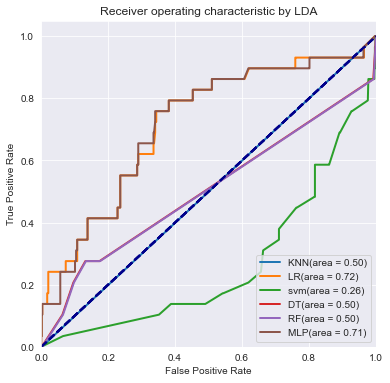

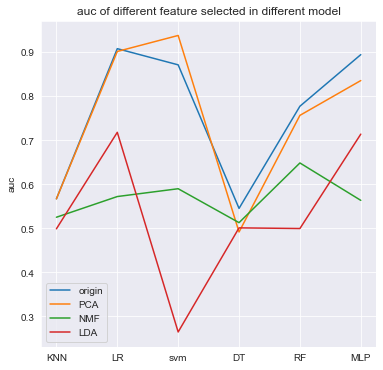

In [21]:
def feature_selection_new():
    for i, method in enumerate(feature_list):
        data_feature = method(data_train, n_components=25)
        X_train, X_test = data_feature.iloc[:5001], data_feature.iloc[5001:]
        y_train, y_test = data['patient_addmited_to_regular_ward_(1=yes,_0=no)'][:5001], data['patient_addmited_to_regular_ward_(1=yes,_0=no)'][5001:]
        f1_score_train, f1_score_test, final_model = model_select(X_train, X_test, y_train, y_test)
        f1_vs_plot(f1_score_train, f1_score_test, feature_name_list[i])
        roc_plot_all_model(X_train, X_test, y_train, y_test, final_model, feature_name_list[i])
feature_selection_new()
# 比较不同特征工程的 auc
model_list_name = [x['name'] for x in model_list]
auc_record.index = model_list_name
auc_record.plot(title="auc of different feature selected in different model", ylabel='auc')
auc_record = pd.DataFrame()

通过观察上面的对比图可以发现采用PCA的效果最好，采用每个元素取指数后的NMF和LDA的效果比较差，这和之前的结论相同

个人认为是因为在取指数时对数据产生了一定的扭曲，面对非负矩阵时最好还是采用PCA